In [1]:
import numpy as np

x_train = np.load('X_train.npy')
x_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

print('x train shape', x_train.shape)
print('y train shape', y_train.shape)
print('x test shape', x_test.shape)
print('y test shape', y_test.shape)

print('x train type', x_train.dtype)
print('y train type', y_train.dtype)
print('x test type', x_test.dtype)
print('y test type', y_test.dtype)

x train shape (887, 12)
y train shape (887,)
x test shape (381, 12)
y test shape (381,)
x train type float64
y train type float64
x test type float64
y test type float64


data total (1268,)


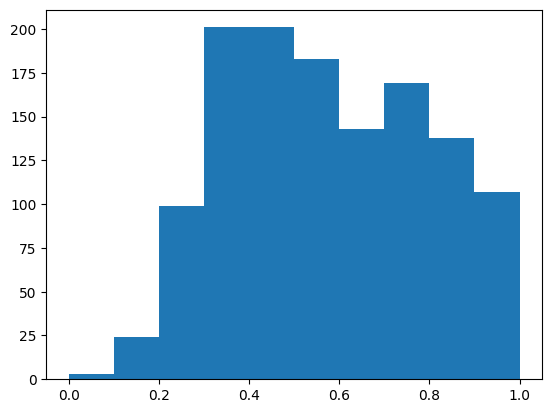

In [2]:
import matplotlib.pyplot as plt

print('data total', np.concatenate((y_train, y_test), axis = 0).shape)
plt.hist(np.concatenate((y_train, y_test), axis = 0));

In [3]:
def mape(real, predict):
    
    """
    Will give MAPE(%) between real and predict values 
    
    """
    
    error = np.abs(real.ravel() - predict.ravel())
    
    real_masked = real.ravel()[real.ravel() != 0]
    error_masked = error.ravel()[real.ravel() != 0]
    
    return np.mean( (error_masked/real_masked) * 100 )


from scipy import stats

def r_squared(real, predict):
    
    """
    Will give R2 (0-1) between real and predict values 
    
    """
    _, _, r_value, _, _ = stats.linregress(real, predict)
    return r_value**2

In [4]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

2.7.1+cu118
True
NVIDIA GeForce GTX 960M


#### Reshaping to (n_samples, n_outputs)

In [5]:
num_of_outputs = 1

x_train_tensor = torch.from_numpy(x_train.astype(np.float32))
x_test_tensor = torch.from_numpy(x_test.astype(np.float32))

y_train_tensor = torch.from_numpy(np.reshape(y_train.astype(np.float32), (-1, num_of_outputs)))
y_test_tensor = torch.from_numpy(np.reshape(y_test.astype(np.float32), (-1, num_of_outputs)))


from torch.utils.data import TensorDataset, DataLoader

train_tesnsordataset = TensorDataset(x_train_tensor, y_train_tensor)
test_tesnsordataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_tesnsordataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_tesnsordataset, batch_size=batch_size, shuffle=True)

In [6]:
import torch.nn as nn

class ANNmodel(nn.Module):
    
    def __init__(self, in_features, hidden_neurons, num_of_outputs):
        
        super().__init__()
        
        self.in_features = in_features
        self.num_of_outputs = num_of_outputs
        self.hidden_neurons = hidden_neurons
        
        self.L1 = nn.Linear(in_features=in_features, out_features=hidden_neurons, bias=True)
        self.A1 = nn.Sigmoid()
        self.L2 = nn.Linear(in_features=hidden_neurons, out_features=num_of_outputs, bias=True)
        
        
    def forward(self, x):
        
        x = self.L1(x)
        x = self.A1(x)
        x = self.L2(x)
        
        return x

In [10]:
device = 'cuda'if torch.cuda.is_available else 'cpu'
device  ='cpu'
model = ANNmodel(in_features=12, hidden_neurons=24, num_of_outputs=1).to(device)

Loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epochs = 200

for epoch in range(epochs):
    
    model.train()
    
    for x_batch, y_batch in train_loader:
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        preds = model(x_batch)
        
        loss = Loss_func(preds, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    
    for x_batch, y_batch in test_loader:
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        preds = model(x_batch)
        
        y_true.append(y_batch.squeeze(1).cpu())
        y_pred.append(preds.squeeze(1).cpu())
        
y_true = torch.cat(y_true, dim=0).numpy()   # (N_test,)
y_pred = torch.cat(y_pred, dim=0).numpy()   # (N_test,)


print('MAPE', mape(y_true, y_pred))
print('R2', r_squared(y_true, y_pred))

MAPE 23.516302
R2 0.6271651731059764


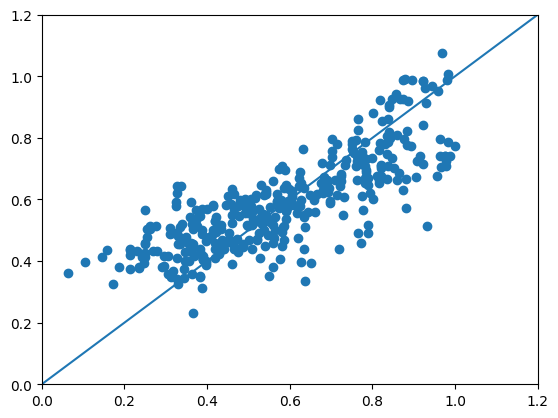

In [8]:
plt.scatter(y_true, y_pred)
plt.xlim([0, 1.2])
plt.ylim([0, 1.2])
plt.plot([0, 1.2], [0,1.2])